In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn as sk
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tools.data_tools import get_files, read_file

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


from sklearn.svm import SVC
from sklearn.cross_validation import KFold


Using TensorFlow backend.


/home/lijing/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [3]:
g = get_files()

In [4]:
g

{'BalanceSheet-Bank.csv': '/home/lijing/.keras/fddc2018-01/BalanceSheet-Bank.csv',
 'BalanceSheet-GeneralBusiness.csv': '/home/lijing/.keras/fddc2018-01/BalanceSheet-GeneralBusiness.csv',
 'BalanceSheet-Insurance.csv': '/home/lijing/.keras/fddc2018-01/BalanceSheet-Insurance.csv',
 'BalanceSheet-Securities.csv': '/home/lijing/.keras/fddc2018-01/BalanceSheet-Securities.csv',
 'CashFlowStatement-Bank.csv': '/home/lijing/.keras/fddc2018-01/CashFlowStatement-Bank.csv',
 'CashFlowStatement-GeneralBusiness.csv': '/home/lijing/.keras/fddc2018-01/CashFlowStatement-GeneralBusiness.csv',
 'CashFlowStatement-Insurance.csv': '/home/lijing/.keras/fddc2018-01/CashFlowStatement-Insurance.csv',
 'CashFlowStatement-Securities.csv': '/home/lijing/.keras/fddc2018-01/CashFlowStatement-Securities.csv',
 'CompanyOperation.csv': '/home/lijing/.keras/fddc2018-01/CompanyOperation.csv',
 'IncomeStatement-Bank.csv': '/home/lijing/.keras/fddc2018-01/IncomeStatement-Bank.csv',
 'IncomeStatement-GeneralBusiness.csv'

In [5]:
def get_data(filename, flist, ticker_symbol, report_type):
    dataframe = read_file(filename)
#     dataframe = dataframe[dataframe['TICKER_SYMBOL'] == ticker_symbol][flist].sort_values(by='END_DATE')
    dataframe = dataframe[flist].sort_values(by='PUBLISH_DATE')
    dataframe = dataframe.drop_duplicates(subset=['TICKER_SYMBOL','END_DATE'], keep='last').reset_index(drop=True)
    dataframe = dataframe[dataframe['REPORT_TYPE'] == report_type]
    dataframe = dataframe.set_index('TICKER_SYMBOL')
    
    return dataframe

In [6]:
cfs_data = get_data('CashFlowStatement-GeneralBusiness.csv',
                   ['TICKER_SYMBOL', 'REPORT_TYPE', 'PUBLISH_DATE',
                    'END_DATE', 'C_FR_SALE_G_S',
                    'N_CHANGE_IN_CASH', 'N_CE_BEG_BAL', 'N_CE_END_BAL'],
                    '000002', 'S1').drop(['REPORT_TYPE', 'PUBLISH_DATE'],axis=1).fillna(method='ffill').fillna(method='bfill')
bs_data = get_data('BalanceSheet-GeneralBusiness.csv',
                  ['TICKER_SYMBOL', 'REPORT_TYPE', 'PUBLISH_DATE',
                   'END_DATE', 'CASH_C_EQUIV',
                   'T_EQUITY_ATTR_P', 'MINORITY_INT', 'T_SH_EQUITY',
                   'T_LIAB_EQUITY'],
                   '000002', 'S1').drop(['REPORT_TYPE', 'PUBLISH_DATE'],axis=1).fillna(method='ffill').fillna(method='bfill')
is_data = get_data('IncomeStatement-GeneralBusiness.csv',
                  ['TICKER_SYMBOL', 'END_DATE', 'REPORT_TYPE', 'PUBLISH_DATE', 'REVENUE'],
                  '000002', 'S1').drop(['REPORT_TYPE', 'PUBLISH_DATE'],axis=1).fillna(method='ffill').fillna(method='bfill')

In [7]:
mask = (cfs_data['END_DATE'] >= '2008-01-01') & (cfs_data['END_DATE'] <= '2016-06-30')
train_cfs_data = cfs_data.loc[mask]
mask = (bs_data['END_DATE'] >= '2008-01-01') & (bs_data['END_DATE'] <= '2016-06-30')
train_bs_data = bs_data.loc[mask]
mask = (is_data['END_DATE'] >= '2008-01-01') & (is_data['END_DATE'] <= '2016-06-30')
train_is_data = is_data.loc[mask]

mask = (cfs_data['END_DATE'] == '2017-06-30')
test_cfs_data = cfs_data.loc[mask]
mask = (bs_data['END_DATE'] == '2017-06-30')
test_bs_data = bs_data.loc[mask]
mask = (is_data['END_DATE'] == '2017-06-30')
test_is_data = is_data.loc[mask]

In [8]:
mask = (bs_data['END_DATE'] == '2009-06-30')
tmp_data = bs_data.loc[mask]
tmp_data['END_DATE'] = pd.to_datetime('2008-06-30')

train_bs_data = train_bs_data.append(tmp_data)

In [9]:
# from 2008-06-30 ~ 2016-06-30 target
y = train_is_data.drop('END_DATE', axis=1)

In [57]:
# create train data
# train_data = train_cfs_data.drop('END_DATE', axis=1)
# train_data = train_data.join(train_bs_data.drop('END_DATE', axis=1))
# train_data = train_data.join(y)

In [133]:
# create train data
# train_data = train_cfs_data
train_data = pd.merge(train_cfs_data, train_bs_data, on=['TICKER_SYMBOL', 'END_DATE'])
train_data = pd.merge(train_data, train_is_data, on=['TICKER_SYMBOL', 'END_DATE'])

In [134]:
train_data = train_data.fillna(method='ffill')

In [143]:
train_data = train_data.drop('END_DATE', axis=1)

In [146]:
test_data = pd.merge(test_cfs_data, test_bs_data, on=['TICKER_SYMBOL', 'END_DATE'])
test_data = test_data.drop('END_DATE', axis=1)
test_data = test_data.fillna(method='ffill')

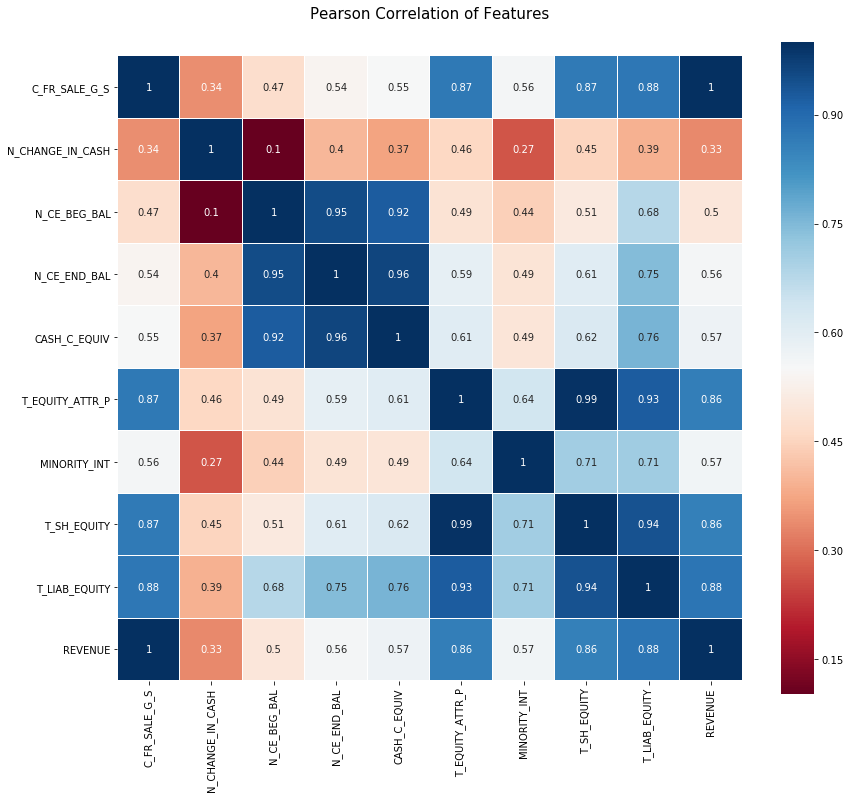

In [147]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [148]:
y_train = train_data['REVENUE'].ravel()
train = train_data.drop(['REVENUE'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test_data.values # Creats an array of the test data

In [149]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [150]:
# Some useful parameters which will come in handy later on
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 4 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train.astype('int'))

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [152]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [153]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [ ]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost 
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

In [ ]:
rf_feature = rf.feature_importances(x_train,y_train.astype('int'))
et_feature = et.feature_importances(x_train, y_train.astype('int'))
ada_feature = ada.feature_importances(x_train, y_train.astype('int'))
gb_feature = gb.feature_importances(x_train,y_train.astype('int'))

In [ ]:
rf_features = [0.077, 0.086, 0.074, 0.095, 0.098, 0.069, 0.073, 0.081, 0.105]
et_features = [0.08033333, 0.12666667, 0.10933333, 0.05566667, 0.077,      0.117,
 0.12033333, 0.13366667, 0.118     ]
ada_features = [0.048, 0.314, 0.112, 0.14,  0.106, 0.062, 0.076, 0.064, 0.078]
gb_features = [0.01820363, 0.06478902, 0.01753671, 0.02239344, 0.02153682, 0.01149377,
 0.01144917, 0.01151205, 0.0143354 ]

In [ ]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [ ]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

In [ ]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [ ]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [ ]:
predictions

In [ ]:
is_data = get_data('IncomeStatement-GeneralBusiness.csv',
                  ['TICKER_SYMBOL', 'END_DATE', 'REPORT_TYPE', 'REVENUE'],
                  '000002', 'S1').reset_index(drop=True)

In [ ]:
is_data